In [1]:
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from ATLAS_data.effFunctions import eventEff,vertexEff
from atlas_susy_2016_08_Recast import (getLLPs, getJets, eventAcc, 
                                       vertexAcc, getModelDict)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution

delphesDir = os.path.abspath("../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['YlGnBu_r']

Welcome to JupyROOT 6.28/06


### ATLAS data

In [13]:
# data_obs = np.genfromtxt('./ATLAS_data/HEPData-ins1630632-v2-csv/Table5.csv',
#                          delimiter=',',skip_header=11,skip_footer=278)
# data_exp = np.genfromtxt('./ATLAS_data/HEPData-ins1630632-v2-csv/Table5.csv',
#                          delimiter=',',skip_header=291)

data_obs = np.genfromtxt('./ATLAS_data/HEPData-ins1630632-v2-csv/Table6.csv',
                         delimiter=',',skip_header=11,skip_footer=113)
data_exp = np.genfromtxt('./ATLAS_data/HEPData-ins1630632-v2-csv/Table6.csv',
                         delimiter=',',skip_header=126)

### Recast Data

In [3]:
# inputFile = './validation/pp2GoGo_Fig7/Events/run_02/gluino_1400_100.0_tau_1e+00_delphes_events.root'
inputFile = './validation/pp2GoGo_Fig7/Events/run_01/gluino_1400_1320.0_tau_1e+00_delphes_events.root'
modelDict = getModelDict([inputFile],model='gluino')

mLLP =  1400.0
width (GeV) =  6.582e-16
tau (ns) =  0.9999999999999999


#### Track Eff = 100%

In [4]:
eff = 1.0
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()
ntotal = 0
totalweightPB = 0.0
lumi = 32.8
mDV_nTracks_weights = []
for ievt in range(nevts):    
   
    ntotal += 1
    tree.GetEntry(ievt)   
    weightPB = tree.Weight.At(1).Weight     
    totalweightPB += weightPB
    ns = weightPB*1e3*lumi # number of signal events

    
    jets = getJets(tree.GenJet,pTmin=25.,etaMax=5.0)
    met = tree.GenMissingET.At(0).MET
    
     # Event acceptance
    evt_acc = eventAcc(jets,met,metCut=200.0,
                       maxJetChargedPT=5.0,minJetPt1=70.,
                       minJetPt2=25.,minPVdistance=4.0)

    if (not evt_acc): continue
    ns = ns*evt_acc

    llps = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters,trackEff=eff)
    # Vertex acceptances:
    v_acc = np.array([vertexAcc(llp,Rmax=300.0,zmax=300.0,Rmin=4.0,
                                        d0min=2.0)  for llp in llps])

    good_llps = np.array(llps)[v_acc > 0.0]
    if len(good_llps) == 0:
        continue
    # Event efficiency
    evt_eff = eventEff(met,good_llps,extrapolate=True)
    ns = ns*evt_eff
    # Vertex efficiencies:
    v_eff = np.array([vertexEff(llp,extrapolate=True) for llp in llps])

    for illp,llp in enumerate(llps):
        wv = v_acc[illp]*v_eff[illp]
        if wv <= 0.:
            continue
        mDV_nTracks_weights.append([llp.mDV,llp.nTracks,ns*wv])

f.Close()

In [5]:
mDV_nTracks_weights = np.array(mDV_nTracks_weights)

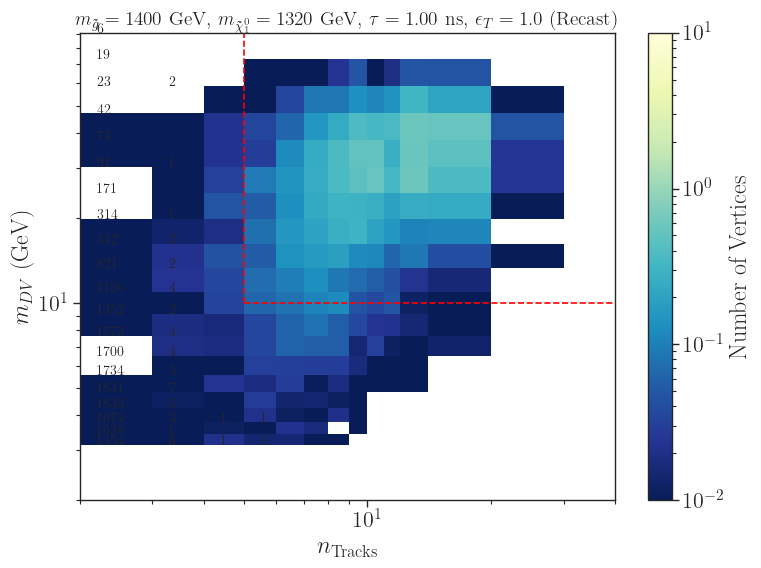

In [20]:
fig = plt.figure(figsize=(8,6))
mDV_bins = np.sort(np.unique(data_exp[:,1]))
n_bins = np.sort((np.unique(data_exp[:,0])))
# mDV_bins = np.append(mDV_bins,np.arange(200.,1000.,100.))
n_bins = np.append(np.unique(data_exp[:,0]),[20.,30.,40.])
h = plt.hist2d(mDV_nTracks_weights[:,1],mDV_nTracks_weights[:,0],cmap=cm,
               weights=mDV_nTracks_weights[:,2],bins=(n_bins,mDV_bins),norm=LogNorm(vmin=1e-2,vmax=10))


for ipt,pt in enumerate(data_obs):
    if pt[-1] == 0.0:
        continue
    plt.text(1.1*pt[0],pt[1],'%i' %pt[-1],fontsize=10)
    
plt.hlines(y=10.0,xmin=5.,xmax=max(n_bins),colors='red',linestyle='dashed')
plt.vlines(x=5.0,ymin=10.,ymax=max(mDV_bins),colors='red',linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$m_{DV}$ (GeV)')
plt.xlabel(r'$n_{\rm Tracks}$')
plt.ylim(2,mDV_bins.max())
plt.xlim(2,40)
fig.colorbar(h[3], ax=plt.gca(),label='Number of Vertices')
plt.title(r'$m_{\tilde g} = %1.0f$ GeV, $m_{\tilde \chi_1^0} = %1.0f$ GeV, $\tau = %1.2f$ ns, $\epsilon_{T} = %1.1f$ (Recast)' 
          %(modelDict['mLLP'],modelDict['mLSP'],modelDict['tau_ns'],eff),fontsize=14)
plt.tight_layout()
plt.show()


#### Track Eff = 50%

In [21]:
effB = 0.5

f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()
ntotal = 0
totalweightPB = 0.0
lumi = 32.8
mDV_nTracks_weightsB = []
for ievt in range(nevts):    
   
    ntotal += 1
    tree.GetEntry(ievt)   
    weightPB = tree.Weight.At(1).Weight     
    totalweightPB += weightPB
    ns = weightPB*1e3*lumi # number of signal events

    
    jets = getJets(tree.GenJet,pTmin=25.,etaMax=5.0)
    met = tree.GenMissingET.At(0).MET
    
     # Event acceptance
    evt_acc = eventAcc(jets,met,metCut=200.0,
                       maxJetChargedPT=5.0,minJetPt1=70.,
                       minJetPt2=25.,minPVdistance=4.0)

    if (not evt_acc): continue
    ns = ns*evt_acc

    llps = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters,trackEff=effB)
    # Vertex acceptances:
    v_acc = np.array([vertexAcc(llp,Rmax=300.0,zmax=300.0,Rmin=4.0,
                                        d0min=2.0)  for llp in llps])

    good_llps = np.array(llps)[v_acc > 0.0]
    if len(good_llps) == 0:
        continue
    # Event efficiency
    evt_eff = eventEff(met,good_llps,extrapolate=True)
    ns = ns*evt_eff
    # Vertex efficiencies:
    v_eff = np.array([vertexEff(llp,extrapolate=True) for llp in llps])

    for illp,llp in enumerate(llps):
        wv = v_acc[illp]*v_eff[illp]
        if wv <= 0.:
            continue
        mDV_nTracks_weightsB.append([llp.mDV,llp.nTracks,ns*wv])

f.Close()

In [22]:
mDV_nTracks_weightsB = np.array(mDV_nTracks_weightsB)

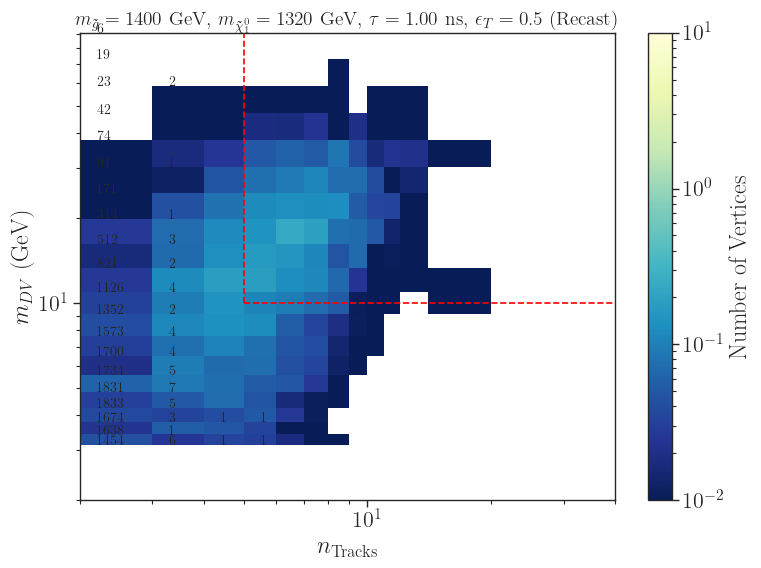

In [23]:
fig = plt.figure(figsize=(8,6))
mDV_bins = np.sort(np.unique(data_exp[:,1]))
n_bins = np.sort((np.unique(data_exp[:,0])))
# mDV_bins = np.append(mDV_bins,np.arange(200.,1000.,100.))
n_bins = np.append(np.unique(data_exp[:,0]),[20.,30.,40.])
h = plt.hist2d(mDV_nTracks_weightsB[:,1],mDV_nTracks_weightsB[:,0],cmap=cm,
               weights=mDV_nTracks_weightsB[:,2],bins=(n_bins,mDV_bins),norm=LogNorm(vmin=1e-2,vmax=10))


for ipt,pt in enumerate(data_obs):
    if pt[-1] == 0.0:
        continue
    plt.text(1.1*pt[0],pt[1],'%i' %pt[-1],fontsize=10)
    
plt.hlines(y=10.0,xmin=5.,xmax=max(n_bins),colors='red',linestyle='dashed')
plt.vlines(x=5.0,ymin=10.,ymax=max(mDV_bins),colors='red',linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$m_{DV}$ (GeV)')
plt.xlabel(r'$n_{\rm Tracks}$')
plt.ylim(2,mDV_bins.max())
plt.xlim(2,40)
fig.colorbar(h[3], ax=plt.gca(),label='Number of Vertices')
plt.title(r'$m_{\tilde g} = %1.0f$ GeV, $m_{\tilde \chi_1^0} = %1.0f$ GeV, $\tau = %1.2f$ ns, $\epsilon_{T} = %1.1f$ (Recast)' 
          %(modelDict['mLLP'],modelDict['mLSP'],modelDict['tau_ns'],effB),fontsize=14)
plt.tight_layout()
plt.show()


### ATLAS Results

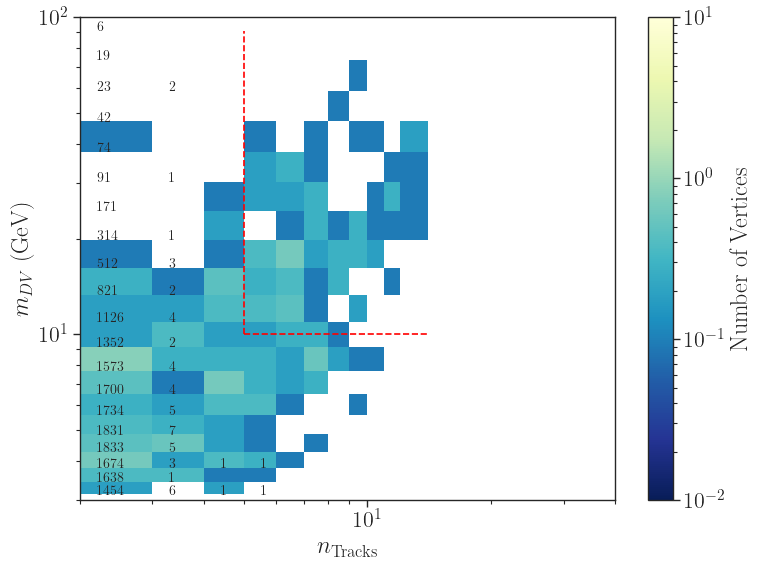

In [24]:
fig = plt.figure(figsize=(8,6))
mDV_bins = sorted(np.unique(data_exp[:,1]))
n_bins = sorted(np.unique(data_exp[:,0]))
h = plt.hist2d(data_exp[:,0],data_exp[:,1],cmap=cm,
               weights=data_exp[:,-1],bins=(n_bins,mDV_bins),norm=LogNorm(vmin=1e-2,vmax=10))

for ipt,pt in enumerate(data_obs):
    if pt[-1] == 0.0:
        continue
    plt.text(1.1*pt[0],pt[1],'%i' %pt[-1],fontsize=10)

plt.hlines(y=10.0,xmin=5.,xmax=max(n_bins),colors='red',linestyle='dashed')
plt.vlines(x=5.0,ymin=10.,ymax=max(mDV_bins),colors='red',linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$m_{DV}$ (GeV)')
plt.xlabel(r'$n_{\rm Tracks}$')
plt.ylim(3,1e2)
plt.xlim(2,40)
fig.colorbar(h[3], ax=plt.gca(),label='Number of Vertices')
# plt.title(r'$m_{\tilde \chi_1^0} = %1.0f$ GeV, $\tau = %1.2f$ ns (ATLAS)' %(modelDict['mLLP'],modelDict['tau_ns']),fontsize=14)
plt.tight_layout()
plt.show()
